# Reproducing [Interpreting Context Look-ups in Transformers: Investigating Attention-MLP Interactions](https://arxiv.org/abs/2402.15055)
- This notebook aims to reproduce `Section 4: Methodology` from Neo et al. 2024

In [1]:
print("Init Reproducing Neo et al. 2024")

Init Reproducing Neo et al. 2024


In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

/Users/kyleng/B_Organized/H_Passion_Projects/mech_interp/reproducing-neo-et-al-2024/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def get_device():
    if torch.cuda.is_available():
        print("Using CUDA GPU")
        return torch.device("cuda")
    else:
        print("Using CPU")
        return torch.device("cpu")
device = get_device()

Using CPU


## 0: Load Model

In [4]:
# Choose model variant
# model_variant = "openai-community/gpt2"
model_variant = "openai-community/gpt2-large"

tokenizer = AutoTokenizer.from_pretrained(
    model_variant,
    output_hidden_states=True,
    output_attentions=True
)
model = AutoModelForCausalLM.from_pretrained(model_variant)

In [5]:
print("Sanity Check that model is loaded: ")
tokenized_sample_input = tokenizer("one two three", return_tensors="pt")

with torch.no_grad():
    model_output = model(**tokenized_sample_input)

next_token_id = model_output.logits[:, -1, :].argmax(dim=-1)

print("Tokenization shape", tokenized_sample_input.input_ids.shape)
print("Model Output shape", model_output.logits.shape)

print("Predicted next token:", tokenizer.decode(next_token_id))

Sanity Check that model is loaded: 
Tokenization shape torch.Size([1, 3])
Model Output shape torch.Size([1, 3, 50257])
Predicted next token:  four


## Model Architecture Analysis

### Model Hyperparameters
- Vocab Size = 50257
- Max Context Length = 1024
- d_model = 768
- n_layers = 12 (0-11)
- d_up = 3072


Note: Conv1D(out, in) = nn.Linear(in, out) [historical GPT2 Reasons]
- Thus, `c_fc` is the up projection and `c_proj` is the down projection
- 2304 / 3 = 768 => QKV projections from residual stream in d_model, with MHA for QKV 

Example with GPT2 Small
```
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768) 
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)
```

In [47]:
N_LAYERS = len(model.transformer.h)
V = model.lm_head.weight.shape[0] # LM Head is shape [V, d_model]
D_UP = model.transformer.h[0].mlp.c_fc.weight.shape[1]

In [7]:
print("Sanity check model architecture")
model

Sanity check model architecture


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1280)
    (wpe): Embedding(1024, 1280)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-35): 36 x GPT2Block(
        (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3840, nx=1280)
          (c_proj): Conv1D(nf=1280, nx=1280)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=5120, nx=1280)
          (c_proj): Conv1D(nf=1280, nx=5120)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1280, out_features=50257, bias=False)
)

## 4.1 Identifying Neurons
To compute the similarity of each W_down column to the token embedding vector e^(t):

We will use the following matrices
```
(c_proj): Conv1D(nf=768, nx=3072) --> linear(out=768, in=3072)
(lm_head): Linear(in_features=768, out_features=50257, bias=False)
```

### First Principles: Finding similarity of Layer 0 token to all unembedding vectors

In [8]:
W_down_layer0_example = model.transformer.h[0].mlp.c_proj.weight.detach() # Layer 0's down projection matrix

print(f"Down projection for layer 0 of shape (d_up, d_model) {W_down_layer0_example.shape} = \n", W_down_layer0_example)

Down projection for layer 0 of shape (d_up, d_model) torch.Size([5120, 1280]) = 
 tensor([[-0.0127,  0.0263, -0.0008,  ..., -0.0288,  0.0315,  0.0074],
        [ 0.0100, -0.0139,  0.0118,  ..., -0.0395, -0.0090,  0.0265],
        [-0.0157, -0.0044,  0.0071,  ..., -0.0052, -0.0036, -0.0005],
        ...,
        [-0.0374,  0.0290, -0.0427,  ...,  0.0282,  0.0498,  0.0568],
        [ 0.0102,  0.0107, -0.0030,  ...,  0.0286, -0.0031,  0.0482],
        [-0.0302, -0.0088, -0.0211,  ..., -0.0421, -0.0037,  0.0082]])


In [9]:
W_unembedding_example = model.lm_head.weight.detach()

print(f"Unembedding matrix of shape (V, d_model) {W_unembedding_example.shape} = \n", W_unembedding_example)

Unembedding matrix of shape (V, d_model) torch.Size([50257, 1280]) = 
 tensor([[-0.0149, -0.0209,  0.0021,  ...,  0.0336, -0.0005, -0.0090],
        [ 0.0055, -0.0438,  0.0013,  ...,  0.0671,  0.0329, -0.0399],
        [ 0.0585,  0.0603,  0.0302,  ..., -0.1041, -0.0566, -0.0330],
        ...,
        [-0.0108, -0.0908,  0.0624,  ..., -0.0337,  0.0777,  0.0293],
        [ 0.0195, -0.0318,  0.0182,  ...,  0.0191, -0.0454, -0.0139],
        [-0.0419,  0.0848, -0.0512,  ..., -0.0083, -0.0447, -0.0274]])


In [10]:
congruence_layer0_example = W_down_layer0_example @ W_unembedding_example.T

print(f"Congruence Score for layer 0 for all tokens of shape (d_up, V) {congruence_layer0_example.shape} ")

Congruence Score for layer 0 for all tokens of shape (d_up, V) torch.Size([5120, 50257]) 


### Extract Congruence Score for each neuron, token, layer

In [11]:
# Find the layer l and neuron i for each congruence 
best_congruence = torch.full((V,), fill_value=-torch.inf)
best_congruence_layer = torch.full((V,), fill_value=-1, dtype=torch.long)
best_congruence_neuron = torch.full((V,), fill_value=-1, dtype=torch.long)

for l in range(N_LAYERS):
    W_unembedding = model.lm_head.weight.detach()
    W_down = model.transformer.h[l].mlp.c_proj.weight.detach() 

    congruence_matrix = W_down @ W_unembedding.T # [d_up, V] 

    layer_best_congruence, layer_best_congruence_neuron = torch.max(congruence_matrix, dim=0)

    better_mask = layer_best_congruence > best_congruence
    
    best_congruence[better_mask] = layer_best_congruence[better_mask]
    best_congruence_layer[better_mask] = l
    best_congruence_neuron[better_mask] = layer_best_congruence_neuron[better_mask]
    
    print("Processed Congruence for layer ", l)

Processed Congruence for layer  0
Processed Congruence for layer  1
Processed Congruence for layer  2
Processed Congruence for layer  3
Processed Congruence for layer  4
Processed Congruence for layer  5
Processed Congruence for layer  6
Processed Congruence for layer  7
Processed Congruence for layer  8
Processed Congruence for layer  9
Processed Congruence for layer  10
Processed Congruence for layer  11
Processed Congruence for layer  12
Processed Congruence for layer  13
Processed Congruence for layer  14
Processed Congruence for layer  15
Processed Congruence for layer  16
Processed Congruence for layer  17
Processed Congruence for layer  18
Processed Congruence for layer  19
Processed Congruence for layer  20
Processed Congruence for layer  21
Processed Congruence for layer  22
Processed Congruence for layer  23
Processed Congruence for layer  24
Processed Congruence for layer  25
Processed Congruence for layer  26
Processed Congruence for layer  27
Processed Congruence for layer

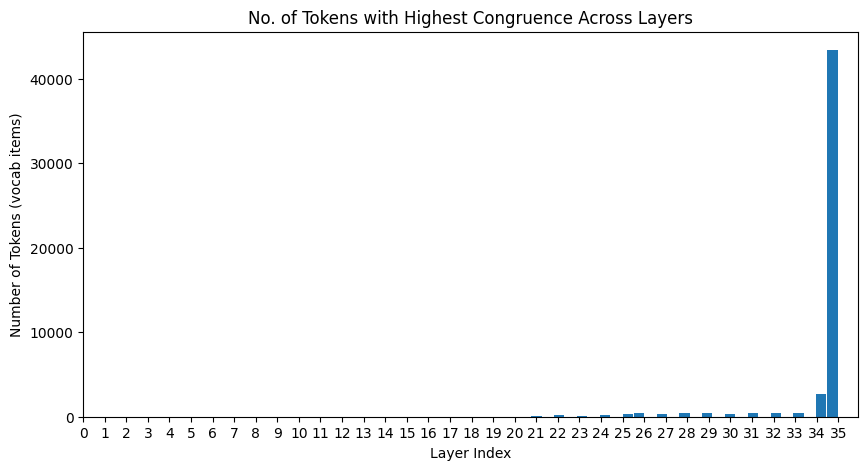

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(best_congruence_layer.cpu().numpy(), bins=N_LAYERS, rwidth=0.9)

plt.title("No. of Tokens with Highest Congruence Across Layers")
plt.xlabel("Layer Index")
plt.ylabel("Number of Tokens (vocab items)")
plt.xticks(range(N_LAYERS))

plt.show()

## Section 4.2 High Activating Prompts

### Register Forward Hooks

In [13]:
import torch
import torch.nn as nn

In [14]:
activations = {}

def save_activation(name: str) -> None:
    def create_save_neuron_hook(module: nn.Module, input: torch.Tensor, output: torch.Tensor) -> None:
        print(f"saving activations of shape {output.shape} to {name}")
        activations[name] = output.detach().cpu()
    return create_save_neuron_hook

In [23]:
# neuron = 
# handler = model.transformer.h[]
handler = model.transformer.h[34].mlp.act.register_forward_hook(save_activation("mlp_34_act"))

In [28]:
activations

{}

In [29]:
print("Sample MLP Activation Extraction: ")
tokenized_sample_input = tokenizer("one two three", return_tensors="pt")

with torch.no_grad():
    model_output = model(**tokenized_sample_input)

Sample MLP Activation Extraction: 
saving activations of shape torch.Size([1, 3, 5120]) to mlp_34_act


In [54]:
activations["mlp_34_act"].shape

torch.Size([1, 3, 5120])

In [55]:
activations["mlp_34_act"][:,:,1]

tensor([[-0.1111, -0.1426, -0.0917]])

In [57]:
torch.argmax(activations["mlp_34_act"], dim=1)

torch.Size([1, 5120])

In [51]:
def get_first_words(s: str, n: int = 3) -> str:
    splitted = s.split()
    return "_".join(splitted[:n])

'hi there my name is'

In [80]:
def phi(prompt: str, layer: int):
    """
    Returns the max activation of all neurons for a given prompt 
    """
    tokenized_prompt = tokenizer(prompt, return_tensors="pt")

    # Save activations to buffer
    buffer_name = f"mlp_{layer}_act_{get_first_words(prompt)}"
    model.transformer.h[layer].mlp.act.register_forward_hook(save_activation(buffer_name))
         
    with torch.no_grad():
        model_output = model(**tokenized_sample_input)

    neuron_activations = torch.max(activations[buffer_name], dim = 1) # torch.max([B, S, d_up], dim = 1) --> [B, d_up]
    return neuron_activations

In [76]:
phi("hi there my name is ", 34)

saving activations of shape torch.Size([1, 3, 5120]) to mlp_34_act_hi there my


torch.return_types.max(
values=tensor([[ 0.1191, -0.0917, -0.0057,  ...,  0.5417, -0.0631,  0.1183]]),
indices=tensor([[0, 2, 0,  ..., 0, 2, 0]]))

In [77]:
activations

{'mlp_34_act_hi there my': tensor([[[ 0.1191, -0.1111, -0.0057,  ...,  0.5417, -0.0972,  0.1183],
          [-0.0391, -0.1426, -0.0871,  ...,  0.1941, -0.1203, -0.1065],
          [-0.0812, -0.0917, -0.0183,  ...,  0.0235, -0.0631, -0.1571]]])}

In [82]:
model.transformer.h[34].mlp.act._forward_hooks

OrderedDict([(4,
              <function __main__.save_activation.<locals>.create_save_neuron_hook(module: torch.nn.modules.module.Module, input: torch.Tensor, output: torch.Tensor) -> None>)])

In [71]:
activations.clear()

In [41]:
# Naive Implementation

prompts = [
    "one two three four ",
    "testing 123 ",
    "a b c d e f g "
]

num_layers_to_extract = 5

for prompt in prompts:
    for l in range(num_layers_to_extract):
         # Forward pass
         tokenized_prompt = tokenizer(prompt, return_tensors="pt")
         
         with torch.no_grad():
            model_output = model(**tokenized_sample_input)
         
         # Save activations to buffer
         buffer_name = f"mlp_{l}_act_{get_first_words(prompt)}"
         model.transformer.h[l].mlp.act.register_forward_hook(save_activation(buffer_name))
         
    # for neuron in range(D_UP):

NameError: name 'pr' is not defined